In [1]:
%%capture
%set_env http_proxy=http://webproxy.eqiad.wmnet:8080
%set_env https_proxy=https://webproxy.eqiad.wmnet:8080
%set_env no_proxy=localhost,127.0.0.1

In [2]:
import wmfdata
wmfdata.utils.insert_code_toggle()

In [3]:
from wmfdata import hive, mariadb
import pandas as pd
from datetime import datetime, timedelta, date

In [4]:
now = pd.Timestamp.utcnow()
today=now.date()
this_monday=(today - timedelta(days=today.weekday())).strftime("%Y-%m-%d")
month_1st_day= datetime.today().replace(day=1).strftime("%Y-%m-%d")


In [5]:
start_date = '2020-01-01'
end_date=this_monday
yr='2020'

In [6]:
weekly_edits_query='''
SELECT WEEKOFYEAR(rev_timestamp) AS week_n, COUNT(*) AS edits
FROM event.mediawiki_revision_create
WHERE year='{YEAR_YYYY}' AND  (rev_timestamp >= '{START_YYYY_MM_DD}' AND rev_timestamp < '{END_YYYY_MM_DD}') 
GROUP BY WEEKOFYEAR(rev_timestamp) 
'''

In [7]:
df_weekly_edits_2020=hive.run(weekly_edits_query.format(YEAR_YYYY=yr, START_YYYY_MM_DD=start_date, END_YYYY_MM_DD=end_date))

In [8]:
monthly_edits_query='''
SELECT month, COUNT(*) AS edits
FROM event.mediawiki_revision_create
WHERE year='{YEAR_YYYY}' AND  (rev_timestamp >= '{START_YYYY_MM_DD}' AND rev_timestamp < '{END_YYYY_MM_DD}') 
GROUP BY month
'''

In [9]:
start_date = '2020-01-01'
end_date=month_1st_day
yr='2020'

df_monthly_edits_2020=hive.run(monthly_edits_query.format(YEAR_YYYY=yr, START_YYYY_MM_DD=start_date, END_YYYY_MM_DD=end_date))

In [10]:
weekly_edits_query_2='''
SELECT
       weekofyear(event_timestamp) AS week_n, COUNT(revision_id) AS edits
FROM wmf.mediawiki_history
WHERE
        event_entity = 'revision' AND
        event_type = 'create' AND
        DATE(event_timestamp) >= '{START_YYYY_MM_DD}' AND DATE(event_timestamp) < '{END_YYYY_MM_DD}' AND
        snapshot = '{SNAPSHOT}'
GROUP BY weekofyear(event_timestamp) 
'''

In [11]:
snapshot = '2020-03'
start_date = '2019-01-01'
end_date='2019-12-31'

In [12]:
df2_weekly_edits_2019_query=hive.run(weekly_edits_query_2.format(SNAPSHOT=snapshot, START_YYYY_MM_DD=start_date, END_YYYY_MM_DD=end_date))

In [13]:
monthly_edits_query_2='''
SELECT
       month(event_timestamp) AS month_n, COUNT(revision_id) AS edits
FROM wmf.mediawiki_history
WHERE
        event_entity = 'revision' AND
        event_type = 'create' AND
        DATE(event_timestamp) >= '{START_YYYY_MM_DD}' AND DATE(event_timestamp) < '{END_YYYY_MM_DD}' AND
        snapshot = '{SNAPSHOT}'
GROUP BY month(event_timestamp) 
'''

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
@ticker.FuncFormatter
def million_formatter(x, pos):
    return "%d M" % round(x/1000000)
@ticker.FuncFormatter
def thousand_formatter(x, pos):
    return "%d K" % round(x/1000)

### Weekly edits trend

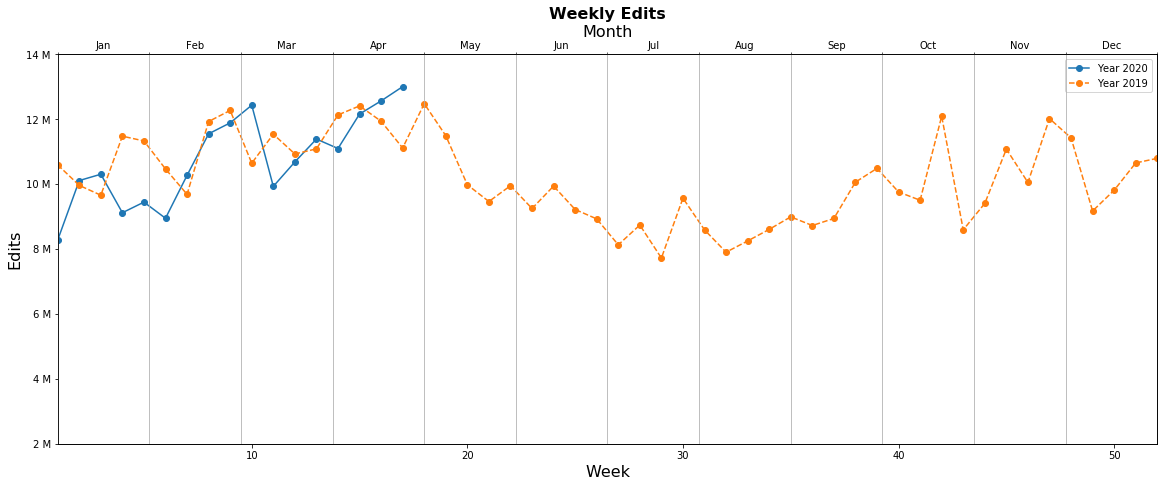

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(16,6))
fig.tight_layout(pad=1.08, w_pad=0.5, h_pad=6)
ax.set_title('Weekly Edits',fontweight="bold",fontsize = 16)
ax.set_xlabel('Week',  fontsize = 16)
ax.set_ylabel('Edits',  fontsize = 16)
ax.plot(df_weekly_edits_2020['week_n'], df_weekly_edits_2020['edits'], 'o-',label='Year 2020')
ax.plot(df2_weekly_edits_2019_query['week_n'], df2_weekly_edits_2019_query['edits'], 'o--',label='Year 2019')

ax.set_xlim(1,52)
ax.set_ylim(2000000,14000000)
ax.legend(loc='upper right')

ax.yaxis.set_major_formatter(million_formatter)

ax2 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax2.set_xlim(0,12)
ax2.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax2.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
ax2.tick_params(length=0)
ax2.set_xlabel('Month',fontsize=16)

miloc = plt.MultipleLocator(1)

ax2.xaxis.set_minor_locator(miloc)
ax2.grid(axis='x', which='minor')
plt.savefig("1_weekly_edits.png")

plt.show()

### Edits by bot editors and non-bot editors

In [16]:
weekly_edits_bot_query='''
SELECT WEEKOFYEAR(rev_timestamp) AS week_n, COUNT(*) AS bot_edits
FROM event.mediawiki_revision_create
WHERE year='{YEAR_YYYY}' AND  (rev_timestamp >= '{START_YYYY_MM_DD}' AND rev_timestamp < '{END_YYYY_MM_DD}') 
AND performer.user_id IS not null
AND  ( performer.user_is_bot=true OR performer.user_text regexp "^.*bot([^a-z].*$|$)")
GROUP BY  WEEKOFYEAR(rev_timestamp) 
'''

In [17]:
weekly_edits_nonbot_query='''
SELECT WEEKOFYEAR(rev_timestamp) AS week_n,  COUNT(*) AS nonbot_edits
FROM event.mediawiki_revision_create
WHERE year='{YEAR_YYYY}' AND  (rev_timestamp >= '{START_YYYY_MM_DD}' AND rev_timestamp < '{END_YYYY_MM_DD}') 
AND performer.user_id IS not null
AND  ( performer.user_is_bot=false AND performer.user_text not regexp "^.*bot([^a-z].*$|$)")
GROUP BY  WEEKOFYEAR(rev_timestamp) 
'''

In [18]:
start_date = '2020-01-01'
end_date=this_monday
yr='2020'

In [19]:
df_weekly_bot_edits_2020=hive.run(weekly_edits_bot_query.format(YEAR_YYYY=yr, START_YYYY_MM_DD=start_date, END_YYYY_MM_DD=end_date))

In [20]:
df_weekly_nonbot_edits_2020=hive.run(weekly_edits_nonbot_query.format(YEAR_YYYY=yr, START_YYYY_MM_DD=start_date, END_YYYY_MM_DD=end_date))

In [21]:
snapshot = '2020-03'
start_date = '2019-01-01'
end_date='2019-12-31'

In [22]:
weekly_edits_bot_query_2='''
SELECT
       weekofyear(event_timestamp) AS week_n, COUNT(revision_id) AS edits
FROM wmf.mediawiki_history
WHERE
        event_entity = 'revision' AND
        event_type = 'create' AND
        DATE(event_timestamp) >= '{START_YYYY_MM_DD}' AND DATE(event_timestamp) < '{END_YYYY_MM_DD}' AND
        event_user_is_anonymous = false AND
        (size(event_user_is_bot_by_historical) > 0 OR size(event_user_is_bot_by) > 0  
        OR event_user_text  regexp "^.*bot([^a-z].*$|$)" )
        AND snapshot = '{SNAPSHOT}'
GROUP BY weekofyear(event_timestamp) 
'''

In [23]:
df2_weekly_bot_edits_2019_query=hive.run(weekly_edits_bot_query_2.format(SNAPSHOT=snapshot, START_YYYY_MM_DD=start_date, END_YYYY_MM_DD=end_date))

In [24]:
weekly_edits_nonbot_query_2='''
SELECT
       weekofyear(event_timestamp) AS week_n, COUNT(revision_id) AS edits
FROM wmf.mediawiki_history
WHERE
        event_entity = 'revision' AND
        event_type = 'create' AND
        DATE(event_timestamp) >= '{START_YYYY_MM_DD}' AND DATE(event_timestamp) < '{END_YYYY_MM_DD}' AND
        event_user_is_anonymous = false AND 
        (size(event_user_is_bot_by_historical) = 0 AND size(event_user_is_bot_by) = 0  
        AND event_user_text not regexp "^.*bot([^a-z].*$|$)" )
        AND snapshot = '{SNAPSHOT}'
GROUP BY weekofyear(event_timestamp) 
'''

In [25]:
df2_weekly_nonbot_edits_2019_query=hive.run(weekly_edits_nonbot_query_2.format(SNAPSHOT=snapshot, START_YYYY_MM_DD=start_date, END_YYYY_MM_DD=end_date))

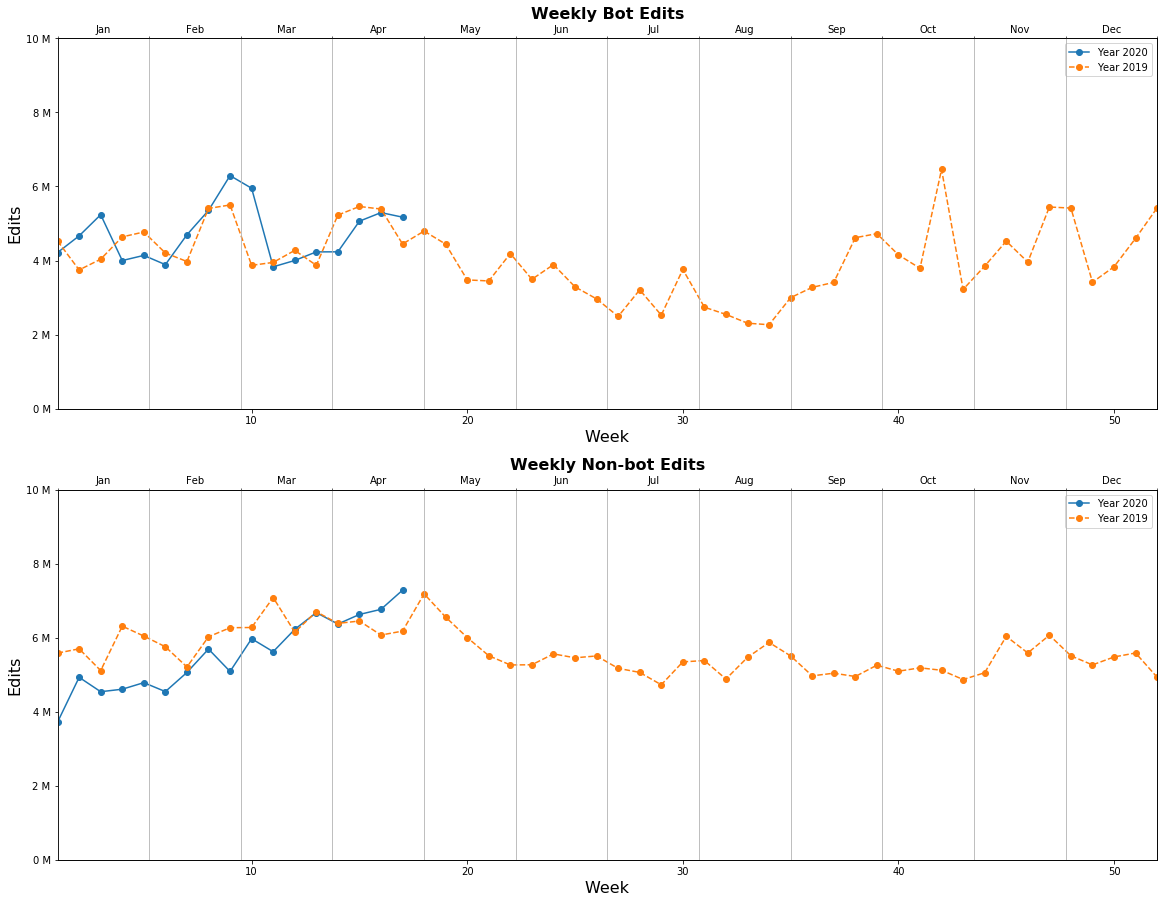

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(16,12))
fig.tight_layout(pad=1.08, w_pad=0.5, h_pad=6)
ax[0].set_title('Weekly Bot Edits',fontweight="bold",fontsize = 16)
ax[0].set_xlabel('Week',  fontsize = 16)
ax[0].set_ylabel('Edits',  fontsize = 16)
ax[0].plot(df_weekly_bot_edits_2020['week_n'], df_weekly_bot_edits_2020['bot_edits'], 'o-',label='Year 2020')
ax[0].plot(df2_weekly_bot_edits_2019_query['week_n'], df2_weekly_bot_edits_2019_query['edits'], 'o--',label='Year 2019')


ax[0].set_xlim(1,52)
ax[0].set_ylim(0,10000000)
ax[0].legend(loc='upper right')
ax[0].yaxis.set_major_formatter(million_formatter)
ax2 = ax[0].twiny()  # instantiate a second axes that shares the same x-axis
ax2.set_xlim(0,12)
ax2.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax2.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
ax2.tick_params(length=0)

miloc = plt.MultipleLocator(1)

ax2.xaxis.set_minor_locator(miloc)
ax2.grid(axis='x', which='minor')

ax[1].set_title('Weekly Non-bot Edits',fontweight="bold",fontsize = 16)
ax[1].set_xlabel('Week',fontsize = 16)
ax[1].set_ylabel('Edits',fontsize = 16)

ax[1].set_xlim(1,52)
ax[1].set_ylim(0,10000000)

ax3=ax[1].twiny()
ax3.set_xlim(0,12)
ax3.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax3.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
ax3.tick_params(length=0)
#ax3.set_xlabel('Month',fontsize=16)
ax3.xaxis.set_minor_locator(miloc)
ax3.grid(axis='x', which='minor')

ax[1].plot(df_weekly_nonbot_edits_2020['week_n'], df_weekly_nonbot_edits_2020['nonbot_edits'], 'o-',label='Year 2020')
ax[1].plot(df2_weekly_nonbot_edits_2019_query['week_n'], df2_weekly_nonbot_edits_2019_query['edits'], 'o--',label='Year 2019')
ax[1].legend(loc='upper right')
ax[1].yaxis.set_major_formatter(million_formatter)
plt.savefig("2_bot_nonbot.png")
plt.show()

### Edits by project families

In [27]:
weekly_edits_family_query='''
SELECT w.database_group , WEEKOFYEAR(rev_timestamp) AS week_n,  COUNT(*) AS edits
FROM event.mediawiki_revision_create AS rv
INNER JOIN canonical_data.wikis AS w ON rv.`database` = w.database_code AND w.database_group IN ('wikipedia','wikidata','commons')
WHERE year='{YEAR_YYYY}' AND  (rev_timestamp >= '{START_YYYY_MM_DD}' AND rev_timestamp < '{END_YYYY_MM_DD}') 
GROUP BY w.database_group , WEEKOFYEAR(rev_timestamp) 
ORDER BY  w.database_group , week_n
LIMIT 1000
'''

In [28]:
start_date = '2020-01-01'
end_date=this_monday
yr='2020'
df_weekly_edits_by_family_2020=hive.run(weekly_edits_family_query.format(YEAR_YYYY=yr, START_YYYY_MM_DD=start_date, END_YYYY_MM_DD=end_date))

In [29]:
weekly_edits_family_query_2='''
SELECT w.database_group ,
       weekofyear(event_timestamp) AS week_n, COUNT(revision_id) AS edits
FROM wmf.mediawiki_history AS h
INNER JOIN canonical_data.wikis AS w ON h.wiki_db = w.database_code AND w.database_group IN ('wikipedia','wikidata','commons')
WHERE
        event_entity = 'revision' AND
        event_type = 'create' AND
        DATE(event_timestamp) >= '{START_YYYY_MM_DD}' AND DATE(event_timestamp) < '{END_YYYY_MM_DD}' AND
        snapshot = '{SNAPSHOT}'
GROUP BY w.database_group , weekofyear(event_timestamp) 
ORDER BY w.database_group, week_n
LIMIT 1000
'''

In [30]:
snapshot = '2020-03'
start_date = '2019-01-01'
end_date='2019-12-31'
df_weekly_edits_by_family_2019=hive.run(weekly_edits_family_query_2.format(SNAPSHOT=snapshot, START_YYYY_MM_DD=start_date, END_YYYY_MM_DD=end_date))

In [31]:
df_weekly_non_wikidata_2020= df_weekly_edits_by_family_2020[df_weekly_edits_by_family_2020['database_group'] !='wikidata'].groupby(['week_n']).sum().reset_index()

In [32]:
df_weekly_non_wikidata_2019=df_weekly_edits_by_family_2019[df_weekly_edits_by_family_2019['database_group'] !='wikidata'].groupby(['week_n']).sum().reset_index()

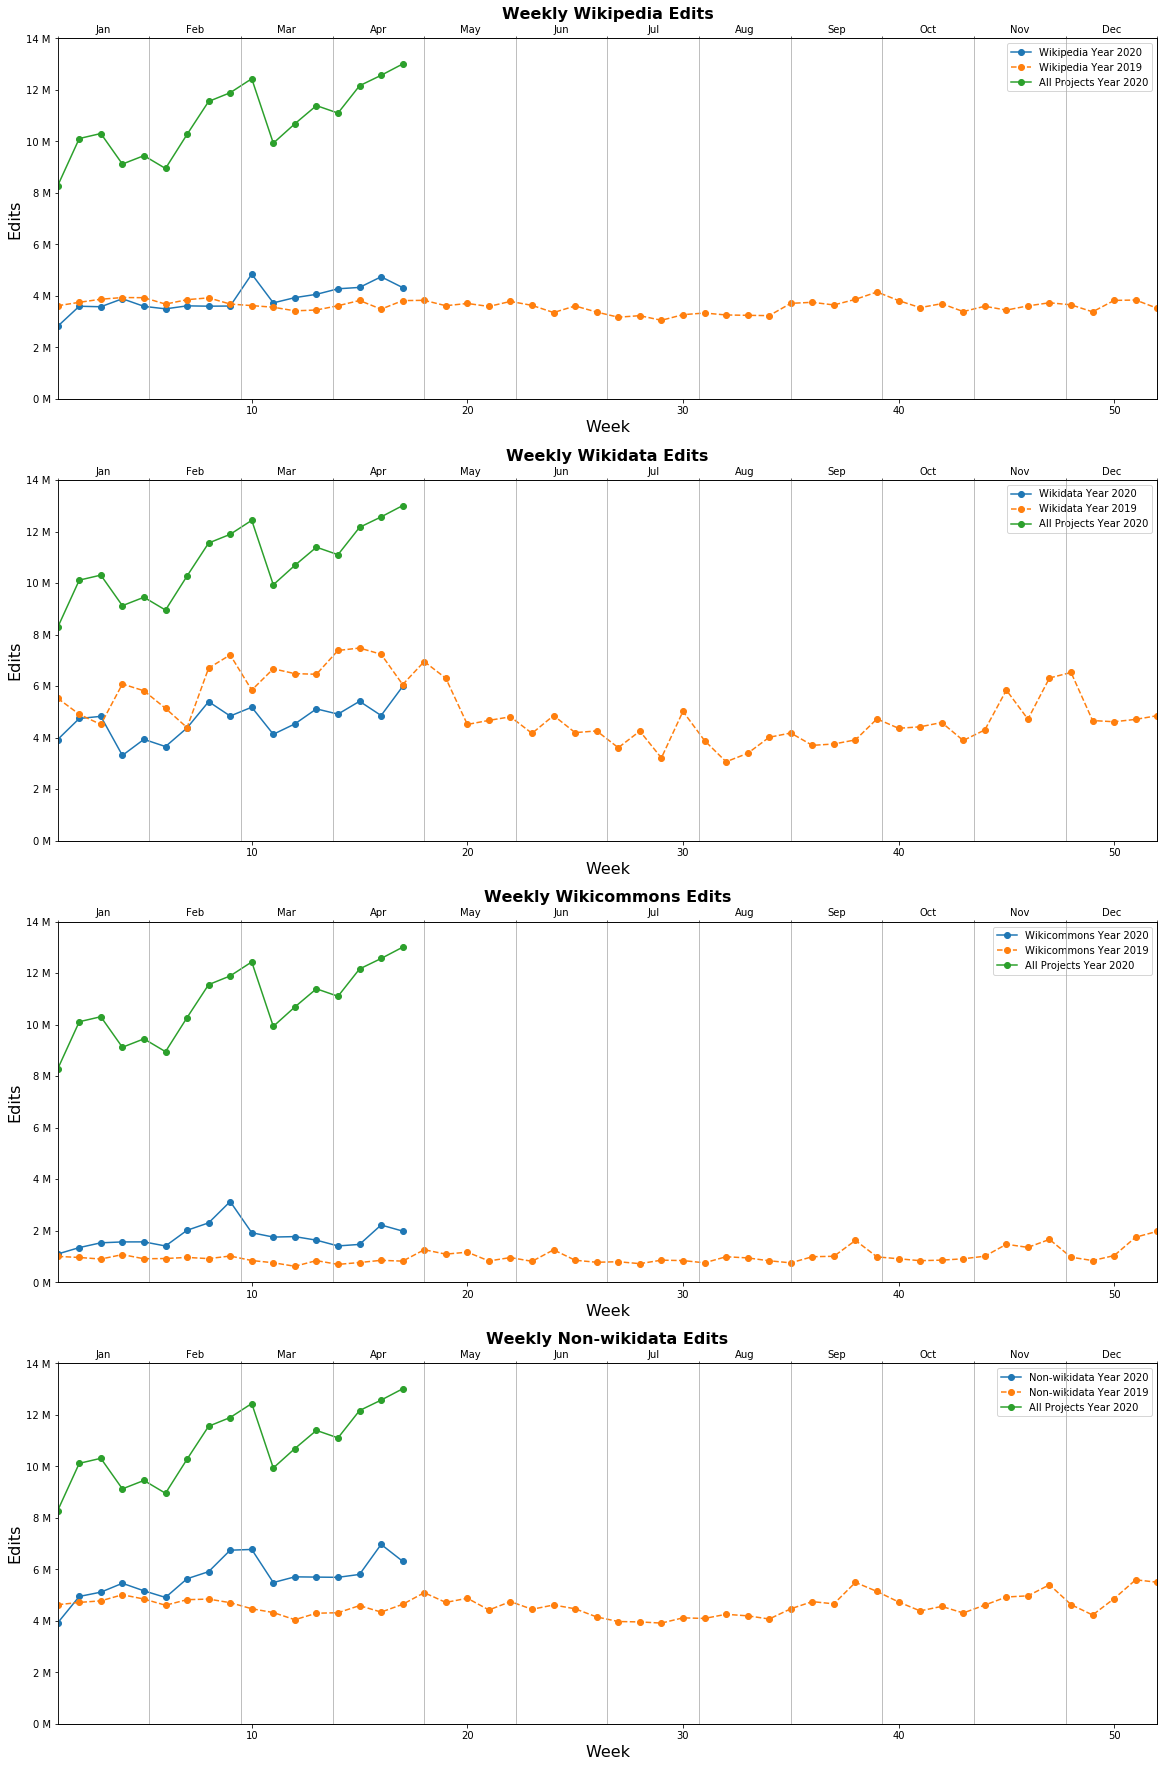

In [33]:
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(16,24))
fig.tight_layout(pad=1.08, w_pad=0.5, h_pad=6)
ax[0].set_title('Weekly Wikipedia Edits',fontweight="bold",fontsize = 16)
ax[0].set_xlabel('Week',  fontsize = 16)
ax[0].set_ylabel('Edits',  fontsize = 16)
ax[0].set_xlim(1,52)
ax[0].set_ylim(0,14000000)
ax[0].plot(df_weekly_edits_by_family_2020[df_weekly_edits_by_family_2020['database_group'] =='wikipedia']['week_n'], df_weekly_edits_by_family_2020[df_weekly_edits_by_family_2020['database_group'] =='wikipedia']['edits'], 'o-',label='Wikipedia Year 2020')
ax[0].plot(df_weekly_edits_by_family_2019[df_weekly_edits_by_family_2019['database_group'] =='wikipedia']['week_n'], df_weekly_edits_by_family_2019[df_weekly_edits_by_family_2019['database_group'] =='wikipedia']['edits'], 'o--',label='Wikipedia Year 2019')
ax[0].plot(df_weekly_edits_2020['week_n'], df_weekly_edits_2020['edits'], 'o-',label='All Projects Year 2020')
ax[0].yaxis.set_major_formatter(million_formatter)
ax[0].legend(loc='upper right')

ax2 = ax[0].twiny()  # instantiate a second axes that shares the same x-axis
ax2.set_xlim(0,12)
ax2.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax2.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
ax2.tick_params(length=0)

miloc = plt.MultipleLocator(1)

ax2.xaxis.set_minor_locator(miloc)
ax2.grid(axis='x', which='minor')

ax[1].set_title('Weekly Wikidata Edits',fontweight="bold",fontsize = 16)
ax[1].set_xlabel('Week',fontsize = 16)
ax[1].set_ylabel('Edits',fontsize = 16)

ax[1].set_xlim(1,52)
ax[1].set_ylim(0,14000000)

ax3=ax[1].twiny()
ax3.set_xlim(0,12)
ax3.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax3.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
ax3.tick_params(length=0)
#ax3.set_xlabel('Month',fontsize=16)
ax3.xaxis.set_minor_locator(miloc)
ax3.grid(axis='x', which='minor')
ax[1].plot(df_weekly_edits_by_family_2020[df_weekly_edits_by_family_2020['database_group'] =='wikidata']['week_n'], df_weekly_edits_by_family_2020[df_weekly_edits_by_family_2020['database_group'] =='wikidata']['edits'], 'o-',label='Wikidata Year 2020')
ax[1].plot(df_weekly_edits_by_family_2019[df_weekly_edits_by_family_2019['database_group'] =='wikidata']['week_n'], df_weekly_edits_by_family_2019[df_weekly_edits_by_family_2019['database_group'] =='wikidata']['edits'], 'o--',label='Wikidata Year 2019')
ax[1].plot(df_weekly_edits_2020['week_n'], df_weekly_edits_2020['edits'], 'o-',label='All Projects Year 2020')
ax[1].legend(loc='upper right')
ax[1].yaxis.set_major_formatter(million_formatter)              
               
ax[2].set_title('Weekly Wikicommons Edits',fontweight="bold",fontsize = 16)
ax[2].set_xlabel('Week',fontsize = 16)
ax[2].set_ylabel('Edits',fontsize = 16)

ax[2].set_xlim(1,52)
ax[2].set_ylim(0,14000000)

ax4=ax[2].twiny()
ax4.set_xlim(0,12)
ax4.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax4.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
ax4.tick_params(length=0)

ax4.xaxis.set_minor_locator(miloc)
ax4.grid(axis='x', which='minor')
ax[2].plot(df_weekly_edits_by_family_2020[df_weekly_edits_by_family_2020['database_group'] =='commons']['week_n'], df_weekly_edits_by_family_2020[df_weekly_edits_by_family_2020['database_group'] =='commons']['edits'], 'o-',label='Wikicommons Year 2020')
ax[2].plot(df_weekly_edits_by_family_2019[df_weekly_edits_by_family_2019['database_group'] =='commons']['week_n'], df_weekly_edits_by_family_2019[df_weekly_edits_by_family_2019['database_group'] =='commons']['edits'], 'o--',label='Wikicommons Year 2019')
ax[2].plot(df_weekly_edits_2020['week_n'], df_weekly_edits_2020['edits'], 'o-',label='All Projects Year 2020')
ax[2].legend(loc='upper right')             
ax[2].yaxis.set_major_formatter(million_formatter)   
    
ax[3].set_title('Weekly Non-wikidata Edits',fontweight="bold",fontsize = 16)
ax[3].set_xlabel('Week',fontsize = 16)
ax[3].set_ylabel('Edits',fontsize = 16)

ax[3].set_xlim(1,52)
ax[3].set_ylim(0,14000000)

ax5=ax[3].twiny()
ax5.set_xlim(0,12)
ax5.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax5.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
ax5.tick_params(length=0)

ax5.xaxis.set_minor_locator(miloc)
ax5.grid(axis='x', which='minor')
ax[3].plot(df_weekly_non_wikidata_2020['week_n'], df_weekly_non_wikidata_2020['edits'], 'o-',label='Non-wikidata Year 2020')
ax[3].plot(df_weekly_non_wikidata_2019['week_n'], df_weekly_non_wikidata_2019['edits'], 'o--',label='Non-wikidata Year 2019')
ax[3].plot(df_weekly_edits_2020['week_n'], df_weekly_edits_2020['edits'], 'o-',label='All Projects Year 2020')
ax[3].legend(loc='upper right')     
ax[3].yaxis.set_major_formatter(million_formatter)   
plt.savefig("3_projects_edits.png")
plt.show()

### Weekly active editors (registered users)
Note: <br> 
The definition of weekly editors is different from that of monthly editors. Monthly active editors is defined as the number of registered users who made at least 5 content edits across all projects in the given month ([Product data dictionary](https://www.mediawiki.org/wiki/Wikimedia_Product/Data_dictionary#Core_metrics)). When defining weekly editors, considering the threshold of 5 content edits per week would be too high, it is defined as the number of registered users who made at least 1 content edit across all projects in the given week, which represents an approximately equivalent frequency to 5 edits per month for monthly active editors. Given weekly editors definition adopts a lower threshold , it captures less frequent editors, resulting in sum of weekly editors being higher than that of monthly editors for the same time period.


In [34]:
weekly_user_editors_query='''
SELECT tmp.week_n, COUNT(tmp.user_id) AS user_editors
FROM
(SELECT  WEEKOFYEAR(rev_timestamp) AS week_n, `database`, performer.user_id AS user_id, max(performer.user_text) AS user_text
FROM event.mediawiki_revision_create
WHERE year='{YEAR_YYYY}' AND  (rev_timestamp >= '{START_YYYY_MM_DD}' AND rev_timestamp < '{END_YYYY_MM_DD}') 
AND performer.user_id IS NOT null 
AND page_namespace IN (0,6,12,640,100,102,104,106,108,110,112,114,124,146,250,252) 
GROUP BY   WEEKOFYEAR(rev_timestamp), `database`, performer.user_id 
)AS tmp
GROUP BY tmp.week_n
'''

In [35]:
start_date = '2020-01-01'
end_date=this_monday
yr='2020'
df_weekly_user_editors_2020=hive.run(weekly_user_editors_query.format(YEAR_YYYY=yr, START_YYYY_MM_DD=start_date, END_YYYY_MM_DD=end_date))

In [36]:
monthly_user_editors_query='''
SELECT tmp.month_n, COUNT(tmp.user_id) AS user_editors
FROM
(SELECT  month(rev_timestamp) AS month_n, `database`, performer.user_id AS user_id, max(performer.user_text) AS user_text
FROM event.mediawiki_revision_create
WHERE year='{YEAR_YYYY}' AND  (rev_timestamp >= '{START_YYYY_MM_DD}' AND rev_timestamp < '{END_YYYY_MM_DD}') 
AND performer.user_id IS NOT null 
AND page_namespace IN (0,6,12,640,100,102,104,106,108,110,112,114,124,146,250,252) 
GROUP BY   month(rev_timestamp), `database`, performer.user_id 
)AS tmp
GROUP BY tmp.month_n
'''


In [37]:
start_date = '2020-01-01'
end_date=month_1st_day
yr='2020'
df_monthly_user_editors_2020=hive.run(monthly_user_editors_query.format(YEAR_YYYY=yr, START_YYYY_MM_DD=start_date, END_YYYY_MM_DD=end_date))

In [38]:
weekly_user_editors_query='''
SELECT tmp.week_n,  SUM(tmp.wiki_user_editors) AS user_editors
FROM
(SELECT
       weekofyear(event_timestamp) AS week_n,wiki_db, COUNT(DISTINCT event_user_id) wiki_user_editors
FROM wmf.mediawiki_history
WHERE
        event_entity = 'revision' AND
        event_type = 'create' AND
        DATE(event_timestamp) >= '{START_YYYY_MM_DD}' AND DATE(event_timestamp) < '{END_YYYY_MM_DD}' AND
        event_user_is_anonymous = false  AND page_namespace_is_content
        AND snapshot = '{SNAPSHOT}'
GROUP BY weekofyear(event_timestamp) ,wiki_db
) AS tmp
GROUP BY tmp.week_n
'''

In [39]:
snapshot = '2020-03'
start_date = '2019-01-01'
end_date='2019-12-31'
df2_weekly_user_editors_2019=hive.run(weekly_user_editors_query.format(SNAPSHOT=snapshot, START_YYYY_MM_DD=start_date, END_YYYY_MM_DD=end_date))

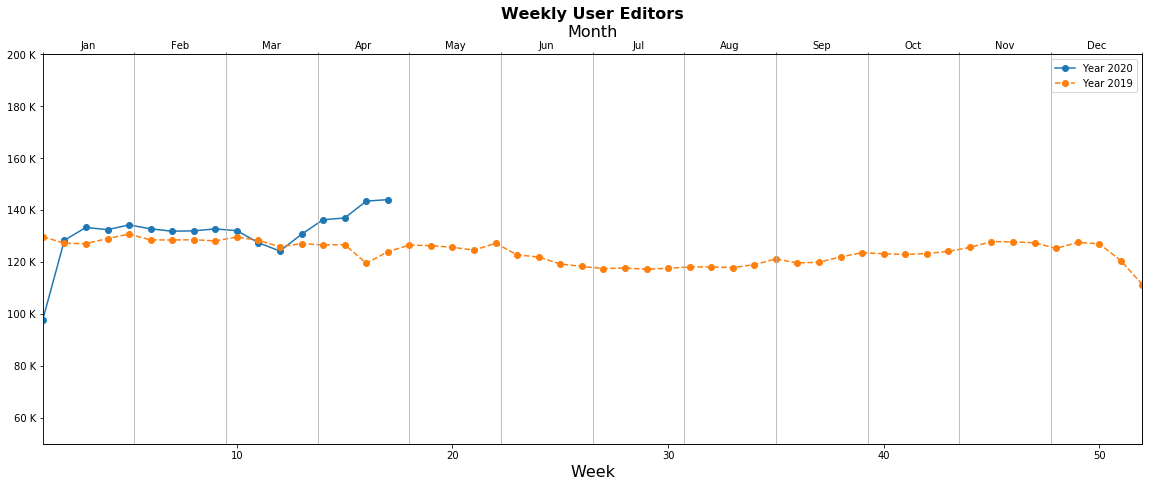

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(16,6))
fig.tight_layout(pad=1.08, w_pad=0.5, h_pad=6)
ax.set_title('Weekly User Editors',fontweight="bold",fontsize = 16)
ax.set_xlabel('Week',  fontsize = 16)


ax.plot(df_weekly_user_editors_2020['week_n'], df_weekly_user_editors_2020['user_editors'], 'o-',label='Year 2020')
ax.plot(df2_weekly_user_editors_2019['week_n'], df2_weekly_user_editors_2019['user_editors'], 'o--',label='Year 2019')
ax.set_xlim(1,52)
ax.set_ylim(50000,200000)
ax.legend(loc='upper right')
ax.yaxis.set_major_formatter(thousand_formatter)
ax2 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax2.set_xlim(0,12)
ax2.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax2.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
ax2.tick_params(length=0)
ax2.set_xlabel('Month',fontsize=16)
                    

miloc = plt.MultipleLocator(1)

ax2.xaxis.set_minor_locator(miloc)
ax2.grid(axis='x', which='minor')
plt.savefig("4_user_editors.png")
plt.show()

### Weekly unique IPs for non-logged-in editors

In [41]:
weekly_ip_editors_query='''
SELECT WEEKOFYEAR(rev_timestamp) AS week_n, COUNT(DISTINCT performer.user_text) AS ip_editors
FROM event.mediawiki_revision_create
WHERE year='{YEAR_YYYY}' AND  (rev_timestamp >= '{START_YYYY_MM_DD}' AND rev_timestamp < '{END_YYYY_MM_DD}') 
AND performer.user_id IS null 
AND page_namespace IN (0,6,12,640,100,102,104,106,108,110,112,114,124,146,250,252) 
GROUP BY  WEEKOFYEAR(rev_timestamp) 
'''

In [42]:
start_date = '2020-01-01'
end_date=this_monday
yr='2020'
df_weekly_ip_editors_2020=hive.run(weekly_ip_editors_query.format(YEAR_YYYY=yr, START_YYYY_MM_DD=start_date, END_YYYY_MM_DD=end_date))

In [43]:
monthly_ip_editors_query='''
SELECT month(rev_timestamp) AS month_n, COUNT(DISTINCT performer.user_text) AS ip_editors
FROM event.mediawiki_revision_create
WHERE year='{YEAR_YYYY}' AND  (rev_timestamp >= '{START_YYYY_MM_DD}' AND rev_timestamp < '{END_YYYY_MM_DD}') 
AND performer.user_id IS null 
AND page_namespace IN (0,6,12,640,100,102,104,106,108,110,112,114,124,146,250,252) 
GROUP BY  month(rev_timestamp) 
'''

In [44]:
start_date = '2020-01-01'
end_date=month_1st_day
yr='2020'
df_monthly_ip_editors_2020=hive.run(monthly_ip_editors_query.format(YEAR_YYYY=yr, START_YYYY_MM_DD=start_date, END_YYYY_MM_DD=end_date))

In [45]:
weekly_ip_editors_query_2='''
SELECT
       weekofyear(event_timestamp) AS week_n, COUNT(DISTINCT event_user_text) AS ip_editors
FROM wmf.mediawiki_history
WHERE
        event_entity = 'revision' AND
        event_type = 'create' AND
        DATE(event_timestamp) >= '{START_YYYY_MM_DD}' AND DATE(event_timestamp) < '{END_YYYY_MM_DD}' AND
        event_user_is_anonymous = true  AND page_namespace_is_content
        AND snapshot = '{SNAPSHOT}'
GROUP BY weekofyear(event_timestamp) 
'''

In [46]:
snapshot = '2020-03'
start_date = '2019-01-01'
end_date='2019-12-31'
df2_weekly_ip_editors_2019=hive.run(weekly_ip_editors_query_2.format(SNAPSHOT=snapshot, START_YYYY_MM_DD=start_date, END_YYYY_MM_DD=end_date))

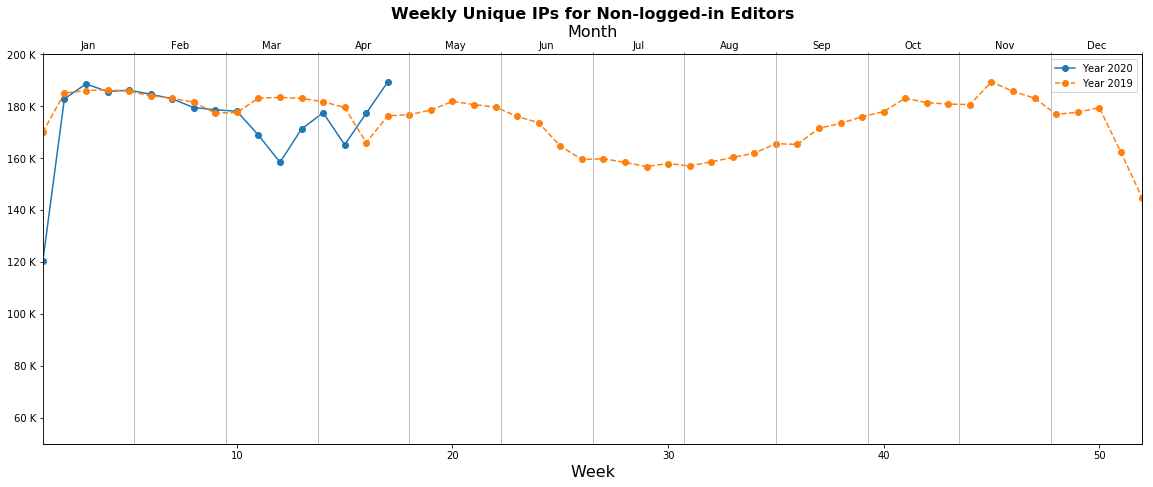

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(16,6))
fig.tight_layout(pad=1.08, w_pad=0.5, h_pad=6)
ax.set_title('Weekly Unique IPs for Non-logged-in Editors',fontweight="bold",fontsize = 16)
ax.set_xlabel('Week',  fontsize = 16)

ax.plot(df_weekly_ip_editors_2020['week_n'], df_weekly_ip_editors_2020['ip_editors'], 'o-',label='Year 2020')
ax.plot(df2_weekly_ip_editors_2019['week_n'], df2_weekly_ip_editors_2019['ip_editors'], 'o--',label='Year 2019')
ax.set_xlim(1,52)
ax.set_ylim(50000,200000)
ax.legend(loc='upper right')
ax.yaxis.set_major_formatter(thousand_formatter)
ax2 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax2.set_xlim(0,12)
ax2.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax2.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
ax2.tick_params(length=0)
ax2.set_xlabel('Month',fontsize=16)
                    

miloc = plt.MultipleLocator(1)

ax2.xaxis.set_minor_locator(miloc)
ax2.grid(axis='x', which='minor')
plt.savefig("5_ip_editors.png")
plt.show()

In [48]:


print("This dashboard was generated on {} at {}.".format(today.strftime("%Y-%m-%d"), now.strftime("%H:%M %Z")))



This dashboard was generated on 2020-04-27 at 16:24 UTC.
